In [1]:
import platform
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

import time
from scipy.stats import randint as sp_randint
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, SCORERS
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.externals import joblib
from operator import itemgetter

from tabulate import tabulate
print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is.conda i...........', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)

class Timer:
  def __init__(self):
    self.start = time.time()

  def restart(self):
    self.start = time.time()

  def get_time(self):
    end = time.time()
    m, s = divmod(end - self.start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

def Correlation_plot(df):
    plt.ioff()
    red_green = ["#ff0000", "#00ff00"]
    sns.set_palette(red_green)
    np.seterr(divide='ignore', invalid='ignore')
    g = sns.pairplot(df,
                    diag_kind = 'kde',
                    hue = 'click',
                    markers = ["o", "D"],
                    size = 1.5,
                    aspect = 1,
                    plot_kws = {"s": 6})
    g.fig.subplots_adjust(right = 0.9)
    plt.show()

def LoadData():
    global X_train, y_train, X_test, y_test, train, test 
    global feature_columns, response_column, n_features
    
    model_full = pd.read_csv("./newsletter_sent.csv",sep=';')
    
#    id;click;email;gender;age;click_rate;geo;device

    response_column = ['click']
    feature_columns = ['id','email', 'gender', 'age', 'click_rate','geo','device']
    n_features = len(feature_columns)
    mask = feature_columns + response_column
    
    model = model_full[mask]
    print('Model dataset:\n', model.head(5))
    print('\nDescription of model dataset:\n', model[feature_columns].describe(include='all'))
    
    Correlation_plot(model)

    # Split the data into Train and Test with Train having 80% and test 20% each
    train_full, test_full = np.split(model_full.sample(frac=1), [int(.8*len(model))])

    X_train  = train_full[feature_columns].as_matrix()
    y_train_ = train_full[response_column].as_matrix()
    X_test   = test_full[feature_columns].as_matrix()
    y_test_  = test_full[response_column].as_matrix()
    
    y_train = np.reshape(y_train_, len(y_train_))
    y_test  = np.reshape(y_test_,  len(y_test_))
    
    train = train_full[mask]
    test  = test_full[mask]
    print('Shape of train: ', train.shape)
    print('Shape of test:  ', test.shape)
    return

def ROC_Curve(rf, auc):
    one_hot_encoder = OneHotEncoder()
    rf_fit = rf.fit(X_train, y_train)
    fit = one_hot_encoder.fit(rf.apply(X_train))
    y_predicted = rf.predict_proba(X_test)[:, 1]
    false_positive, true_positive, _ = roc_curve(y_test, y_predicted)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (area = %0.2f)' % auc)
    plt.legend(loc='best')
    plt.show()


def Print_Metrics(saved_rf):
    print('\nModel performance on the test data set:')

    # print('Train Accuracy.......', accuracy_score(y_train, best_model.predict(X_train)))
    # print('Validate Accuracy....', accuracy_score(y_valid, best_model.predict(X_valid)))

    y_predict_test  = best_model.predict(X_test)
    mse             = metrics.mean_squared_error(y_test, y_predict_test)
    logloss_test    = metrics.log_loss(y_test, y_predict_test)
    accuracy_test   = metrics.accuracy_score(y_test, y_predict_test)
    accuracy_test2  = best_model.score(X_test, y_test)
    F1_test         = metrics.f1_score(y_test, y_predict_test)
    precision_test  = precision_score(y_test, y_predict_test, average='binary')
    precision_test2 = metrics.precision_score(y_test, y_predict_test)
    recall_test     = recall_score(y_test, y_predict_test, average='binary')
    auc_test        = metrics.roc_auc_score(y_test, y_predict_test)
    r2_test         = metrics.r2_score(y_test, y_predict_test)

    #test_auc       = h2o.get_model("best_rf").model_performance(test_data=test).auc()
    #print('Best model performance based on auc: ', test_auc)
    
    header = ["Metric", "Test"]
    table  = [
            ["logloss",   logloss_test],
            ["accuracy",  accuracy_test],
            ["precision", precision_test],
            ["F1",        F1_test],
            ["r2",        r2_test],
            ["AUC",       auc_test]
            ]

    print(tabulate(table, header, tablefmt="fancy_grid"))


def Plot_predictor_importance(best_model, feature_columns):
    feature_importance = best_model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    y_pos  = np.arange(sorted_idx.shape[0]) + .5
    fig, ax = plt.subplots()
    ax.barh(y_pos, 
            feature_importance[sorted_idx], 
            align='center', 
            color='green', 
            ecolor='black', 
            height=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_columns)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Importance')
    ax.set_title('Predictor Importance')
    plt.show()

def Report_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def Print_confusion_matrix(cm, auc, heading):
    print('\n', heading)
    print(cm)
    true_negative  = cm[0,0]
    true_positive  = cm[1,1]
    false_negative = cm[1,0]
    false_positive = cm[0,1]
    total = true_negative + true_positive + false_negative + false_positive
    accuracy = (true_positive + true_negative)/total
    precision = (true_positive)/(true_positive + false_positive)
    recall = (true_positive)/(true_positive + false_negative)
    misclassification_rate = (false_positive + false_negative)/total
    F1 = (2*true_positive)/(2*true_positive + false_positive + false_negative)
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('F1.......................%7.4f' % F1)
    print('auc......................%7.4f' % auc)

def Plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, y,
                                                            cv = cv,
                                                            n_jobs = n_jobs,
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return

def Random_Search():
    global best_model, saved_moldel
    param_grid = {"n_estimators": range(20, 100, 2),
                  "max_depth": range(4, 50, 2),
                  "min_samples_leaf": range(2, 100, 2),
                  "max_features": sp_randint(1, n_features),
                  "min_samples_split": sp_randint(2, 10),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

    clf = RandomForestClassifier(class_weight = 'balanced')
    n_iter_search = 500
    estimator = RandomizedSearchCV(clf,
                                   param_distributions = param_grid,
                                   n_iter = n_iter_search,
                                   scoring = 'roc_auc',
                                   verbose = 0,
                                   n_jobs = 1)
        
    fit = estimator.fit(X_train, y_train)

    # Cross validation with 20 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv_ = ShuffleSplit(n_splits = 20, test_size = 0.20, random_state = 0)
    Plot_learning_curve(estimator, 
                        'Learning Curves',
                        X_train, y_train, 
                        cv = cv_,
                        n_jobs = 1)
     
    Report_scores(estimator.cv_results_, n_top = 3)   
    best_model = estimator.best_estimator_
    print('\nbest_model:\n', best_model)

    print('\nFeature Importances:', best_model.feature_importances_)
    Plot_predictor_importance(best_model, feature_columns)

    y_predicted = best_model.predict(X_train)
    probabilities = best_model.predict_proba(X_train)

    c_report = classification_report(y_train, y_predicted)
    print('\nClassification report:\n', c_report)

    y_predicted_train = best_model.predict(X_train)
    cm = confusion_matrix(y_train, y_predicted_train)
    auc = roc_auc_score(y_train, y_predicted_train)
    Print_confusion_matrix(cm, auc, 'Confusion matrics of the training dataset')

    y_predicted = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    auc = roc_auc_score(y_test, y_predicted)

    ntotal = len(y_test)
    correct = y_test == y_predicted
    numCorrect = sum(correct)
    percent = round( (100.0*numCorrect)/ntotal, 6)
    print("\nCorrect classifications on test data: {0:d}/{1:d} {2:8.3f}%".format(numCorrect, ntotal, percent))
    prediction_score = 100.0*best_model.score(X_test, y_test)
    print('Random Forest Prediction Score on test data: %8.3f' % prediction_score)

    model_path = 'C:/sm/BottleRockets/trained_models/sklearn_rf_classify.pkl'
    joblib.dump(best_model, model_path)

    saved_model = joblib.load(model_path)
    y_predicted_test = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted_test)
    auc = roc_auc_score(y_test, y_predicted_test)
    Print_confusion_matrix(cm, auc, 'Confusion matrics of the test dataset')
    ROC_Curve(best_model, auc)
    Print_Metrics(saved_model)
    return


Operating system version.... Darwin-18.2.0-x86_64-i386-64bit
Python version is........... 3.6.5
scikit-learn version is..... 0.20.0
pandas version is........... 0.23.4
numpy version is.conda i........... 1.15.3
matplotlib version is....... 3.0.1


Model dataset:
     id  email  gender  age  click_rate  geo  device  click
0   40      1       2   86    0.147128    1       3      1
1   49      2       1   32    0.094582    3       1      0
2   89      2       1   38    0.202300    5       2      1
3  262      4       1   40    0.458359    6       1      0
4  277      1       1   47    0.084073    2       1      0

Description of model dataset:
                  id        email       gender         age   click_rate  \
count   1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean   25258.573000     2.488000     1.376000    52.87500     0.063525   
std    14451.237674     1.742668     0.484622    12.26131     0.357769   
min       40.000000     1.000000     1.000000    19.00000    -1.000000   
25%    12815.500000     1.000000     1.000000    44.00000     0.027751   
50%    25049.500000     2.000000     1.000000    52.00000     0.087696   
75%    38076.000000     3.000000     2.000000    62.00000     0.174230   
max   

/Users/massimo/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


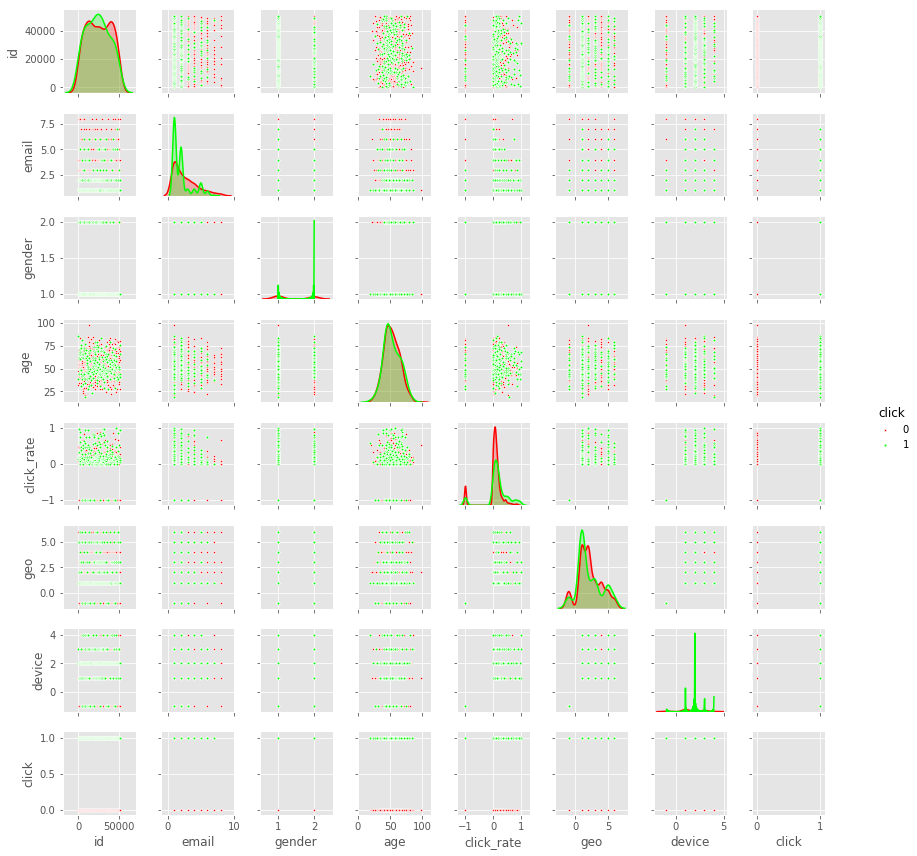

Shape of train:  (800, 8)
Shape of test:   (200, 8)


/Users/massimo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/massimo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/massimo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/massimo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [2]:

my_timer = Timer()
LoadData()


In [3]:
Random_Search()
elapsed = my_timer.get_time()
print("\nTotal compute time was: %s" % elapsed)

/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: T

/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:19

/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:19

/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:19

/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: T

/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/massimo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: T

KeyboardInterrupt: 